<a href="https://colab.research.google.com/github/tosittig/CASAIS/blob/main/W2_4_4_Pretrained_QA_4colab_OUTPUT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question-Answering
Question answering is becoming more and more popular, as people seem to prefer to get answer interactively rather than reading long documents, and information can be found more quickly.

We will the SubjQA dataset, which contains over 10'000 customer reviews in English  in six domains.

**Note:** If you get a `NotImplementedError: Loading a dataset cached in a LocalFileSystem is not supported.` when running the cell `print(subjqa["train"]["answers"][1])`: uncomment the following two `!pip` commands, restart the kernel, and try again.

In [ ]:
!pip install datasets
# !pip install -U typing-extensions
# !pip install fsspec==2023.9.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00


## Preparations

In [ ]:
from datasets import get_dataset_config_names

The `subjqa` has reviews from different domains:

In [ ]:
domains = get_dataset_config_names("subjqa")
domains

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

We will use the feedbacks on electronics:

In [ ]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

Generating train split:   0%|          | 0/1295 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/358 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/255 [00:00<?, ? examples/s]

Let's first look at some examples:

In [ ]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


We re-organize the data into a structure that is more easy to handle:

In [ ]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

And we want to get an overview over how many data points we have:

In [ ]:
for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


Here are some of the most relevant attributes:

In [ ]:
qa_cols = ["title", "question", "answers.text",
           "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [ ]:
sample_df.loc[791, 'context']

"I really like this keyboard.  I give it 4 stars because it doesn't have a CAPS LOCK key so I never know if my caps are on.  But for the price, it really suffices as a wireless keyboard.  I have very large hands and this keyboard is compact, but I have no complaints."

In [ ]:
sample_df.loc[1159, 'context']

"I bought this after the first spare gopro battery I bought wouldn't hold a charge. I have very realistic expectations of this sort of product, I am skeptical of amazing stories of charge time and battery life but I do expect the batteries to hold a charge for a couple of weeks at least and for the charger to work like a charger. In this I was not disappointed. I am a river rafter and found that the gopro burns through power in a hurry so this purchase solved that issue. the batteries held a charge, on shorter trips the extra two batteries were enough and on longer trips I could use my friends JOOS Orange to recharge them.I just bought a newtrent xtreme powerpak and expect to be able to charge these with that so I will not run out of power again."

As mentioned in the slides, we see that some of the answers are grammatically not correct sentences, and some cannot be answered (such as "how is the battery?")

## Span Classification
A popular approach is to define a task to find the start and end token of the context that is contains the answer.

Many models for this are available on e.g., Huggingface Hub. We choose a small one by deepset, a German AI start-up

In [ ]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/107 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on file size."""
inputs = tokenizer(question, context, return_tensors="pt")

As before, we can get the tokens that the tokenizer has generated - and with `tokenizer.decode`, we see how our question and context are represented:

In [ ]:
inputs

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

In [ ]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


After tokenization, we can use the model to predict the start and end token:

In [ ]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3108, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


In [ ]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
token_ids = range(len(tokens))

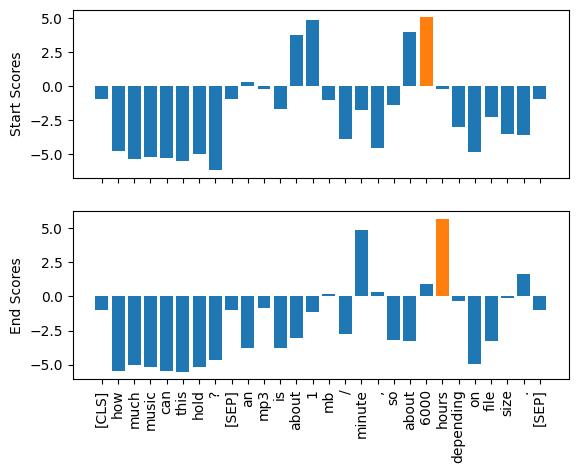

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=token_ids, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=token_ids, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(token_ids, tokens, rotation="vertical")
plt.show()

Putting the components together, we can now get the result:

In [ ]:
start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours
